# CodeBERT Vulnerable Smart Contracts - Evaluation

This notebook evaluates a trained CodeBERT classifier on a test CSV and generates:
- Overall accuracy, average loss, and classification report
- Accuracy and loss figures plotted over evaluation batches
- Dataset visualization: class distribution, length distributions (chars and tokens), token length by class, duplicates summary, and top token frequencies (sampled)

In [1]:
# Install dependencies if needed (uncomment if running in a fresh environment)
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm

Defaulting to user installation because normal site-packages is not writeable
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached torch-2.9.1-cp313-cp313-win_amd64.whl.metadata (30 kB)
  Using cached pandas-2.3.3-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.7-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached numpy-2.3.5-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached pyyaml-6.0.3-cp313-cp313-win_amd64.whl.metadata (2.4 kB)
  Using cached regex-2025.11.3-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cache


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from torch import nn
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import seaborn as sns
from collections import Counter

sns.set(style="whitegrid")

MODEL_NAME = "microsoft/codebert-base"
MODEL_PATH = "codebert_contract_vuln_classifier.pt"
TEST_CSV = "full_contracts_dataset_with_source.csv"  # Or your new test set
MAX_LEN = 256
BATCH_SIZE = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Visualization sampling to avoid heavy computation on very large datasets
N_SAMPLES_FOR_VIZ = 3000  # adjust as needed
TOP_TOKENS_N = 25

LABEL_NAMES = {0: "Secure (0)", 1: "Vulnerable (1)"}

print(f"Using device: {DEVICE}")

C:\Users\Shane\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cpu


## Load and prepare test data

In [3]:
test_path = Path(TEST_CSV)
if not test_path.exists():
    raise FileNotFoundError(f"Test CSV not found: {test_path}")

df = pd.read_csv(TEST_CSV)
df = df[["source_code", "label"]].dropna()
df = df[df["source_code"].str.len() > 0]

# Ensure labels are integers 0/1
df["label"] = df["label"].astype(int)
print(f"Test samples: {len(df)}")
df.head(3)

Test samples: 36671


,source_code,label
0,pragma solidity ^0.4.24;\n\n\ncontract SafeMat...,1
1,pragma solidity ^0.4.11;\n\n/* Ethart unindexe...,0
2,pragma solidity ^0.4.16;\n\n\ncontract EBLCrea...,1


## Dataset Visualization
This section provides quick EDA of the dataset used for evaluation:
- Class distribution
- Character-length distribution (overall and per class)
- Token-length distribution (overall and per class; based on CodeBERT tokenizer)
- Duplicate source code summary
- Top token frequencies (sampled)

C:\Users\Shane\AppData\Local\Temp\ipykernel_13020\1352017925.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="label", data=df, palette="Set2")
C:\Users\Shane\AppData\Local\Temp\ipykernel_13020\1352017925.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([LABEL_NAMES.get(int(x.get_text()), str(x.get_text())) for x in ax.get_xticklabels()])


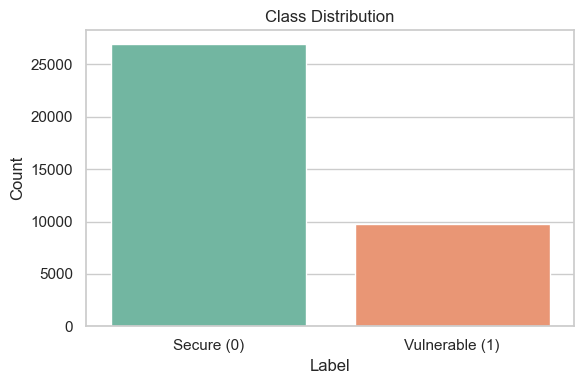

In [4]:
# Class distribution
plt.figure(figsize=(6, 4))
ax = sns.countplot(x="label", data=df, palette="Set2")
ax.set_xticklabels([LABEL_NAMES.get(int(x.get_text()), str(x.get_text())) for x in ax.get_xticklabels()])
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

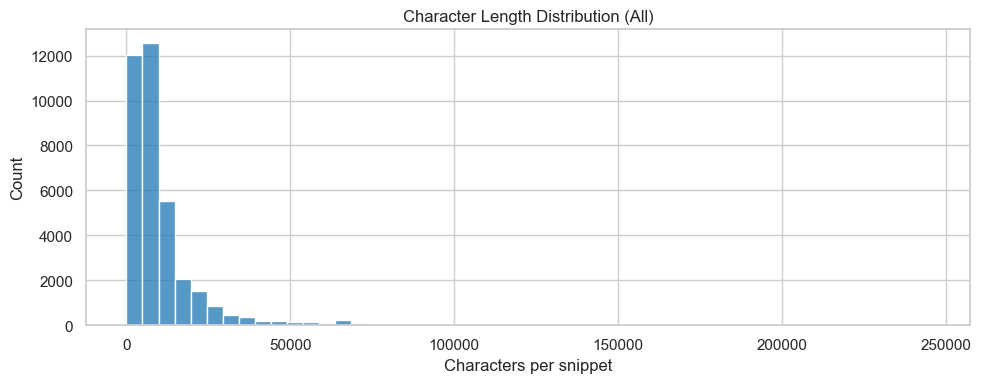

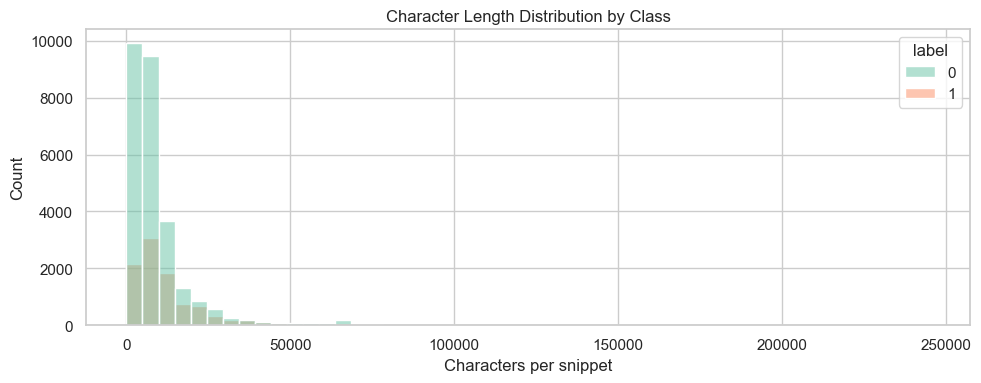

C:\Users\Shane\AppData\Local\Temp\ipykernel_13020\3727022599.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="label", y="char_len", palette="Set2")


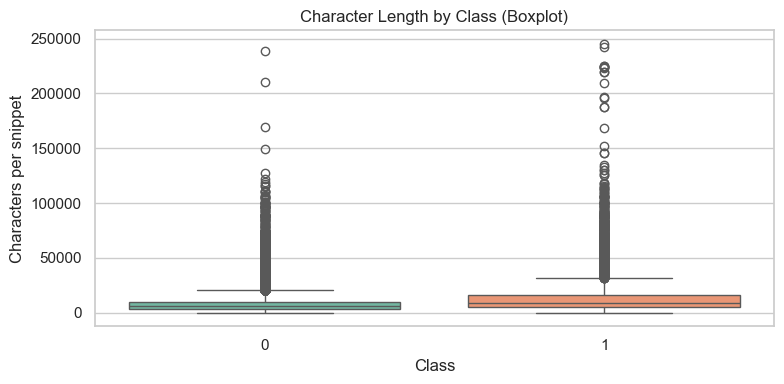

In [5]:
# Character length distributions
df["char_len"] = df["source_code"].str.len()

plt.figure(figsize=(10, 4))
sns.histplot(df["char_len"], bins=50, kde=False, color="tab:blue")
plt.title("Character Length Distribution (All)")
plt.xlabel("Characters per snippet")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data=df, x="char_len", hue="label", bins=50, kde=False, palette="Set2", stat="count")
plt.title("Character Length Distribution by Class")
plt.xlabel("Characters per snippet")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x="label", y="char_len", palette="Set2")
plt.title("Character Length by Class (Boxplot)")
plt.xlabel("Class")
plt.ylabel("Characters per snippet")
plt.tight_layout()
plt.show()

C:\Users\Shane\AppData\Roaming\Python\Python313\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Shane\.cache\huggingface\hub\models--microsoft--codebert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Tokenizing for length: 100%|██████████| 3000/3000 [00:06<00:00, 474.45it/s]


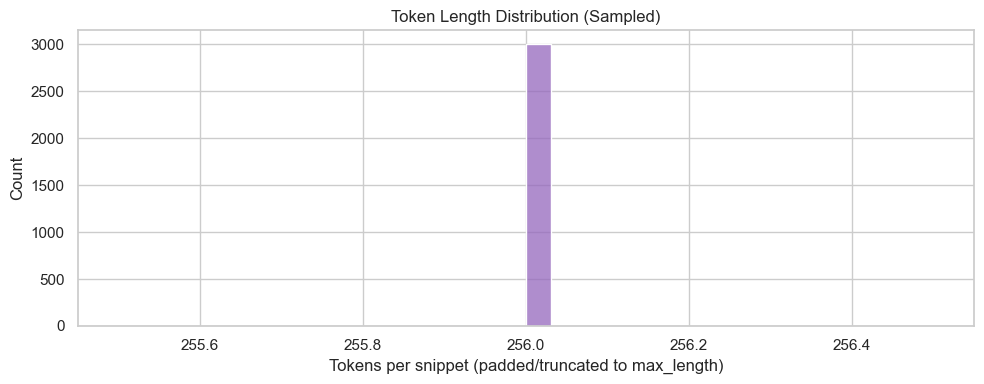

C:\Users\Shane\AppData\Local\Temp\ipykernel_13020\4263682738.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=sample_df, x="label", y="token_len", palette="Set2", cut=0)


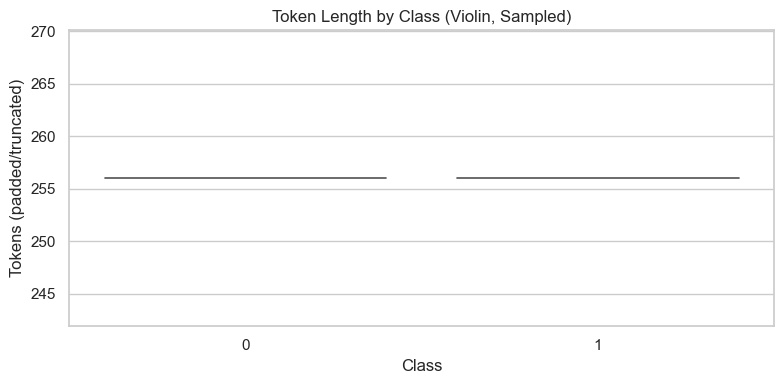

In [6]:
# Token length distributions using the CodeBERT tokenizer (sampled)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

sample_df = df.sample(n=min(N_SAMPLES_FOR_VIZ, len(df)), random_state=42).copy()

def token_len(text: str, max_len: int = MAX_LEN) -> int:
    enc = tokenizer(
        str(text)[:5000],
        truncation=True,
        padding="max_length",
        max_length=max_len,
        return_tensors="pt",
    )
    return int(enc["input_ids"].shape[1])

tqdm.pandas(desc="Tokenizing for length")
sample_df["token_len"] = sample_df["source_code"].progress_apply(lambda s: token_len(s, MAX_LEN))

plt.figure(figsize=(10, 4))
sns.histplot(sample_df["token_len"], bins=MAX_LEN//8, kde=False, color="tab:purple")
plt.title("Token Length Distribution (Sampled)")
plt.xlabel("Tokens per snippet (padded/truncated to max_length)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 4))
sns.violinplot(data=sample_df, x="label", y="token_len", palette="Set2", cut=0)
plt.title("Token Length by Class (Violin, Sampled)")
plt.xlabel("Class")
plt.ylabel("Tokens (padded/truncated)")
plt.tight_layout()
plt.show()

In [9]:
# Duplicate source code summary
dup_mask = df.duplicated(subset=["source_code"], keep=False)
num_dups = dup_mask.sum()
num_unique = df.shape[0] - df["source_code"].nunique()
print(f"Total rows: {len(df)}")
print(f"Duplicate rows (any repeated source_code): {num_dups}")
print(f"Rows part of duplicated groups (len(df) - nunique): {num_unique}")

# Show a few duplicate groups if present
if num_dups > 0:
    dup_examples = df[dup_mask].groupby("source_code").head(2).reset_index(drop=True).head(6)
    print("\nSample duplicate entries:")
    display(dup_examples)
else:
    print("No duplicate source_code entries detected.")

Total rows: 36671
Duplicate rows (any repeated source_code): 4
Rows part of duplicated groups (len(df) - nunique): 2

Sample duplicate entries:


,source_code,label,char_len
0,pragma solidity ^0.4.12;\n\n/**\n * @title Saf...,0,11051
1,pragma solidity ^0.4.4;\n\ncontract Token {\n\...,0,6402
2,pragma solidity ^0.4.12;\n\n/**\n * @title Saf...,1,11051
3,pragma solidity ^0.4.4;\n\ncontract Token {\n\...,0,6402


Counting tokens: 100%|██████████| 3000/3000 [00:06<00:00, 433.01it/s]
C:\Users\Shane\AppData\Local\Temp\ipykernel_13020\10337746.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_df, x="count", y="token", palette="viridis")


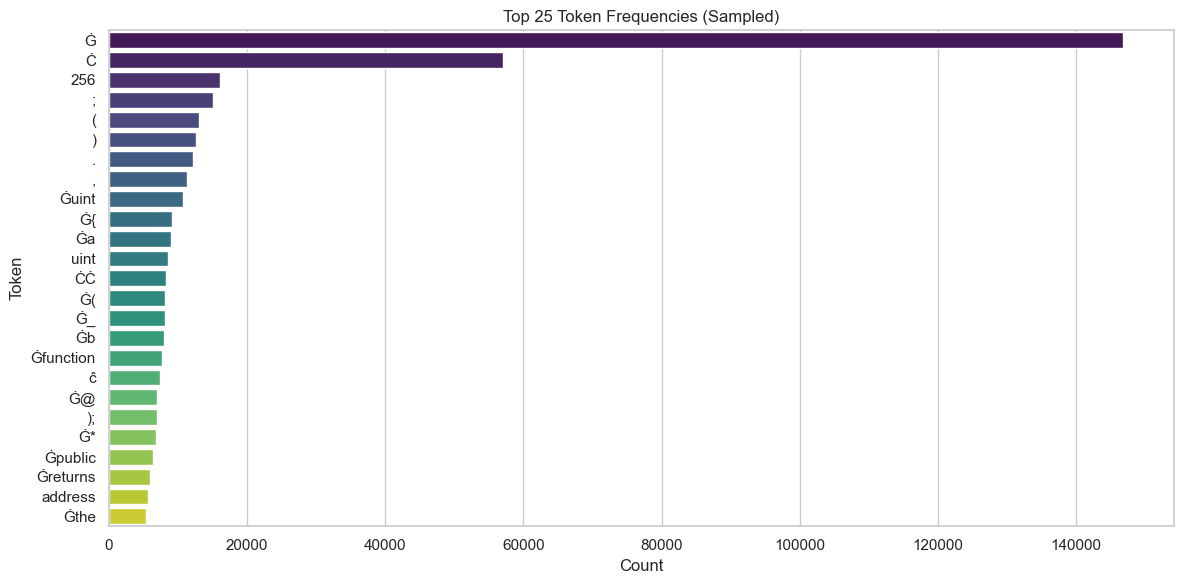

,token,count
0,Ġ,146847
1,Ċ,57098
2,256,16014
3,;,15109
4,(,13020
5,),12549
6,.,12090
7,",",11303
8,Ġuint,10782
9,Ġ{,9070


In [10]:
# Top token frequencies (sampled) excluding special tokens
special_tokens = set([tokenizer.cls_token, tokenizer.sep_token, tokenizer.pad_token, tokenizer.unk_token])
token_counter = Counter()

for text in tqdm(sample_df["source_code"].tolist(), desc="Counting tokens"):
    enc = tokenizer(
        str(text)[:5000],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN,
        return_tensors="pt",
    )
    ids = enc["input_ids"].squeeze(0).tolist()
    toks = tokenizer.convert_ids_to_tokens(ids)
    for t in toks:
        if t not in special_tokens:
            token_counter[t] += 1

top_tokens = token_counter.most_common(TOP_TOKENS_N)
top_df = pd.DataFrame(top_tokens, columns=["token", "count"])

plt.figure(figsize=(12, 6))
sns.barplot(data=top_df, x="count", y="token", palette="viridis")
plt.title(f"Top {TOP_TOKENS_N} Token Frequencies (Sampled)")
plt.xlabel("Count")
plt.ylabel("Token")
plt.tight_layout()
plt.show()

top_df.head(10)

## Dataset and DataLoader
We define the dataset and dataloader for evaluation.

In [11]:
class ContractDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts = df["source_code"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        code = str(self.texts[idx])[:5000]
        enc = self.tokenizer(
            code,
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        input_ids = enc["input_ids"].squeeze(0)
        attn_mask = enc["attention_mask"].squeeze(0)
        label = torch.tensor(self.labels[idx], dtype=torch.float)
        return input_ids, attn_mask, label

test_ds = ContractDataset(df, tokenizer, MAX_LEN)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)
len(test_ds)

36671

## Define and load the model

In [12]:
class CodeBERTClassifier(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.backbone = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.backbone.config.hidden_size, 1)

    def forward(self, input_ids, attn_mask):
        outputs = self.backbone(input_ids=input_ids, attention_mask=attn_mask)
        cls_rep = outputs.last_hidden_state[:, 0, :]
        x = self.dropout(cls_rep)
        logits = self.fc(x)
        return logits

model = CodeBERTClassifier(MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model.eval()
print("Model loaded and set to eval mode.")

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


Model loaded and set to eval mode.


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


## Evaluate: batch-wise loss and accuracy, overall metrics, and classification report

In [13]:
bce_logits = nn.BCEWithLogitsLoss(reduction="mean")

preds, trues = [], []
batch_losses = []
batch_accuracies = []

with torch.no_grad():
    for input_ids, attn_mask, labels in tqdm(test_loader, desc="Evaluating"):
        input_ids, attn_mask = input_ids.to(DEVICE), attn_mask.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(input_ids, attn_mask).squeeze(-1)
        loss = bce_logits(logits, labels)

        probs = torch.sigmoid(logits)
        batch_preds = (probs > 0.5).long()

        batch_losses.append(loss.item())
        batch_acc = (batch_preds.cpu() == labels.cpu().long()).float().mean().item()
        batch_accuracies.append(batch_acc)

        preds.extend(batch_preds.cpu().numpy().tolist())
        trues.extend(labels.cpu().long().numpy().tolist())

overall_accuracy = accuracy_score(trues, preds)
average_loss = float(np.mean(batch_losses))

print(f"Overall Accuracy: {overall_accuracy:.4f}")
print(f"Average Loss (BCEWithLogits): {average_loss:.4f}")
print(classification_report(trues, preds, digits=4))

Evaluating: 100%|██████████| 9168/9168 [1:11:36<00:00,  2.13it/s]

Overall Accuracy: 0.8390
Average Loss (BCEWithLogits): 0.3751
              precision    recall  f1-score   support

           0     0.8627    0.9284    0.8943     26915
           1     0.7499    0.5924    0.6619      9756

    accuracy                         0.8390     36671
   macro avg     0.8063    0.7604    0.7781     36671
weighted avg     0.8327    0.8390    0.8325     36671



## Plot Accuracy and Loss over batches

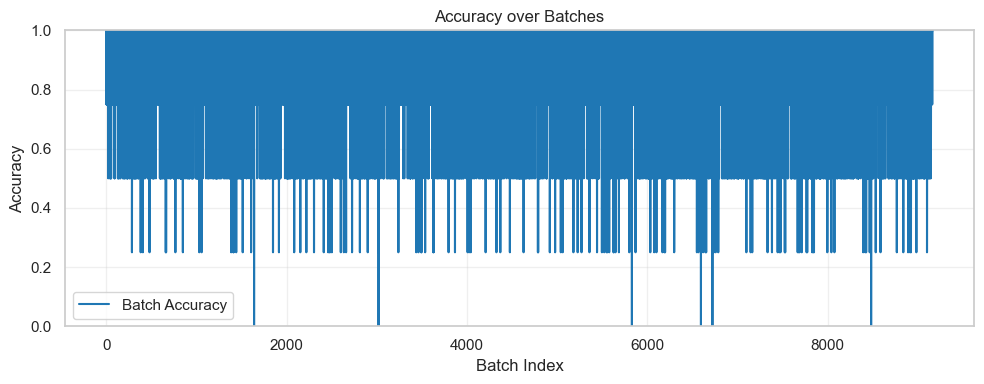

In [14]:
plt.figure(figsize=(10, 4))
plt.plot(batch_accuracies, label="Batch Accuracy", color="tab:blue")
plt.title("Accuracy over Batches")
plt.xlabel("Batch Index")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

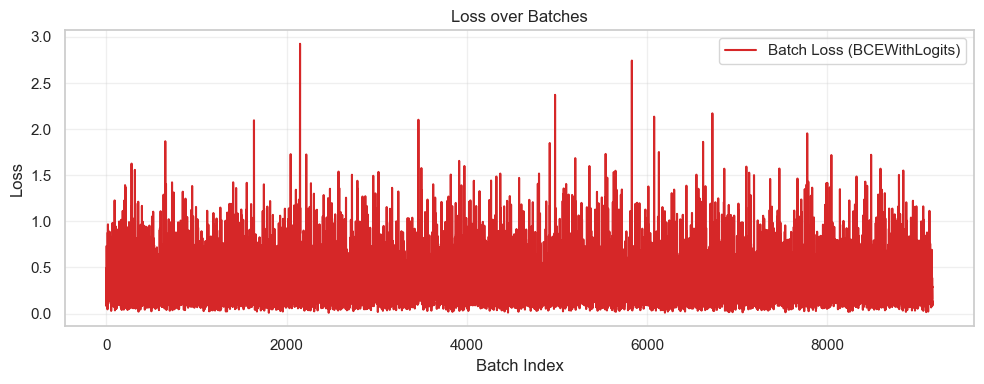

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(batch_losses, label="Batch Loss (BCEWithLogits)", color="tab:red")
plt.title("Loss over Batches")
plt.xlabel("Batch Index")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()